In [107]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

In [108]:
personal_folders = [
    "person-1", 
    "person-2", 
    "person-3", 
    "person-4", 
    "person-5",
    "person-6", 
    "person-7", 
    "person-8", 
    "person-9", 
    "person-10",
    "person-11", 
    "person-12", 
    "person-13", 
    "person-14", 
    "person-15"
]

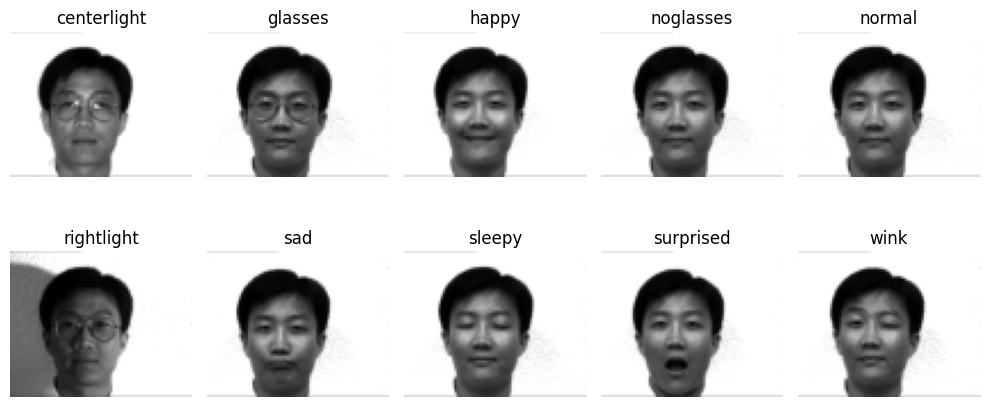

In [109]:
person_folder = random.choice(personal_folders)

plt.figure(figsize=(10, 5))
base_path = r"C:\Users\Admin\Documents\Đại học\DS102 - Học máy thống kê\Thực Hành\BTHH3\yalefaces"

for i, file in enumerate(os.listdir(os.path.join(base_path, person_folder))):
    image = imread(os.path.join(base_path, person_folder, file))
    image = image.squeeze()
    image = resize(image, (64, 80), anti_aliasing=True)
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(file)
    
    if i >= 9:
        break

plt.tight_layout()
plt.show()


In [110]:
data = {}
for person_folder in personal_folders:
    for file in os.listdir(os.path.join(base_path, person_folder)):
        image = imread(os.path.join(base_path, person_folder, file))
        image = resize(image, (1, 64, 80), anti_aliasing=True)
        if person_folder not in data:
            data[person_folder] = [image]
        else:
            data[person_folder].append(image)

for person in data:
    n_images = len(data[person])
    data[person] = np.concatenate(data[person], axis=0).reshape(n_images, -1)

In [111]:
data['person-1'].shape

(10, 5120)

## Standarding images

In [112]:
class Standardize:
    def fit(self, X):
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        return self

    def transform(self, X):
        return ((X - self.mean_) / (self.std_ + 1e-8)).astype(np.float32)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

## Principle Components Analysis

In [113]:
class PCA:
    def __init__(self, n_components=1):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.explained_variance = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov_matrix = np.dot(X_centered.T, X_centered) / (X_centered.shape[0] - 1)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        self.explained_variance = eigenvalues[:self.n_components]
        self.components = eigenvectors[:, :self.n_components]
        return self

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [114]:
PCA = PCA(n_components=20)

image = []
for person in data:
    image.append(data[person])

image = np.concatenate(image, axis=0)
print(image.shape)

(150, 5120)


In [115]:
PCA.fit(image)

In [116]:
PCA.components.shape

(5120, 20)

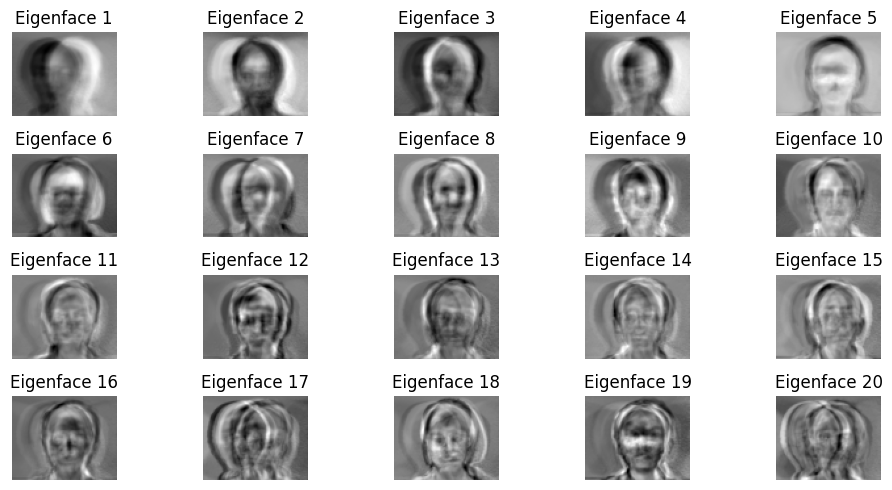

In [117]:
eigen_faces = PCA.components.T
eigen_faces = eigen_faces.reshape(20, 64, 80)
plt.figure(figsize=(10, 5))
for i, eigen_face in enumerate(eigen_faces):
    plt.subplot(4, 5, i+1)
    plt.imshow(eigen_face, cmap='gray')
    plt.axis('off')
    plt.title(f'Eigenface {i+1}')

plt.tight_layout()
plt.show()

## Finding the Mean Faces

In [118]:
mean_faces = {
    person: np.mean(images, axis=0) for person, images in data.items()
}

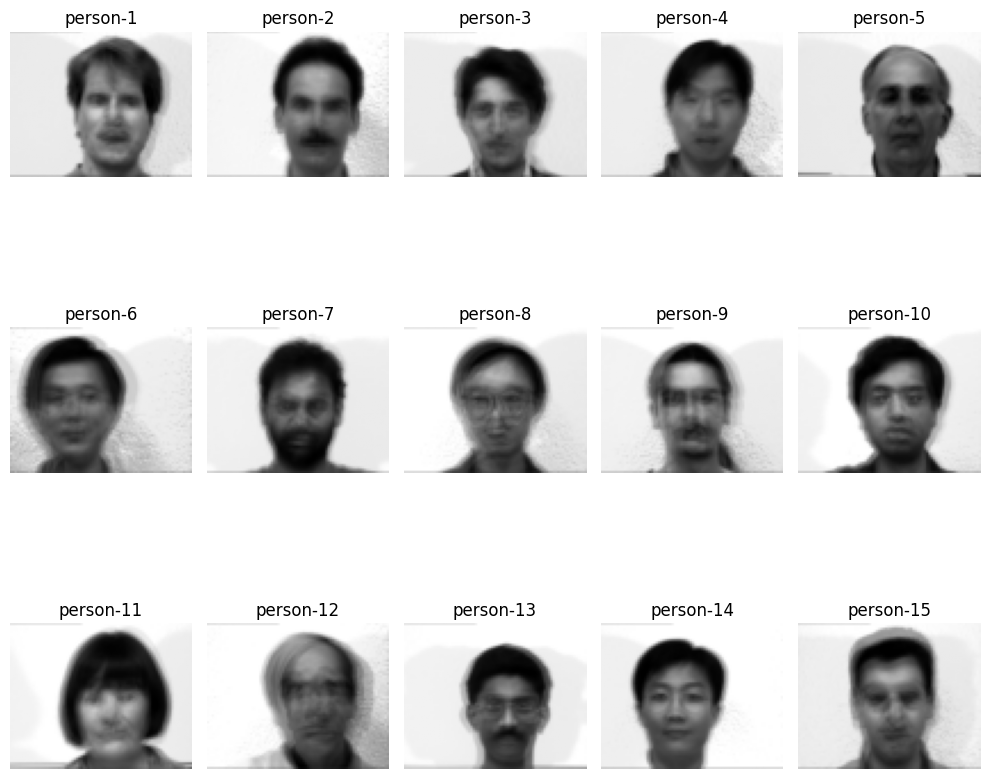

In [119]:
plt.figure(figsize=(10, 10))
for ith, person in enumerate(mean_faces):
    mean_face = mean_faces[person]
    mean_face = mean_face.reshape(64, 80)
    plt.subplot(3, 5, ith+1)
    plt.imshow(mean_face, cmap='gray')
    plt.axis('off')
    plt.title(person)

plt.tight_layout()
plt.show()

In [120]:
projected_mean_faces = {}
for person in mean_faces:
    mean_face = mean_faces[person]
    projected_mean_faces[person] = PCA.transform(mean_faces[person])

In [121]:
labels = []
test_images = []
test_path = 'yalefaces/test'
for file in os.listdir(os.path.join(test_path)):
    person_name = file.split('.')[0]
    labels.append(person_name)
    
    image = imread(os.path.join(test_path, file))
    image = resize(image, (1, 64, 80), anti_aliasing=True)
    test_images.append(image)

In [122]:
test_images = np.concatenate(test_images, axis=0)
test_images.shape

(15, 64, 80)

In [123]:
labels

['person-1',
 'person-10',
 'person-11',
 'person-12',
 'person-13',
 'person-14',
 'person-15',
 'person-2',
 'person-3',
 'person-4',
 'person-5',
 'person-6',
 'person-7',
 'person-8',
 'person-9']

In [124]:
def euclid_dis(X, Y):
    assert X.shape == Y.shape, f"{X.__str__()} and {Y.__str__()} are miss-shaped"
    return (((X - Y)**2).sum())**0.5

In [125]:
predict = {}
for label, image in zip(labels, test_images):
    image = image.reshape(-1)
    projected_face = PCA.transform(image)
    closest_dis = np.inf
    closest_person = None
    for person in projected_mean_faces:
        mean_face = projected_mean_faces[person]
        dis = euclid_dis(mean_face, projected_face)
        if dis < closest_dis:
            closest_dis = dis
            closest_person = person
            
    predict[label] = closest_person

In [126]:
EMS = []
for label in predict:
    EMS.append(label == predict[label])
    
print(f'Accuracy: {np.mean(EMS)*100:0.2f}')

Accuracy: 66.67
